
# Melanoma Detection Case Study

### Problem Statement:
- To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Import the libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import PIL

import warnings
warnings.filterwarnings('ignore')

## Import Data

Set the **'use_colab'** variable to *True* in the below cell to use the colab and drive platform.

In [2]:
# Set use_colab = True if using google colab
use_colab = True
folder_prefix = ''

if use_colab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  folder_prefix = "/content/gdrive/MyDrive/Upgrad/MelanomaDetection/"

Mounted at /content/gdrive


In [3]:
# specify train and test data
train_data = pathlib.Path(folder_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data = pathlib.Path(folder_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
train_count = len(list(train_data.glob('*/*.jpg')))
print("count of Train images : ",train_count)
image_count_test = len(list(train_data.glob('*/*.jpg')))
print("count of Test images  : ",image_count_test)

count of Train images :  2239
count of Test images  :  2239


---
<a id='dataset_create'></a>
### Dataset creation

Define parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

The image_batch consists of a tensor with dimensions (32, 180, 180, 3), representing a batch containing 32 images sized 180x180 pixels with three color channels in RGB format. The label_batch, a tensor of shape (32,), contains the associated labels for these 32 images.

#### Load using keras.preprocessing

Utilizing the convenient image_dataset_from_directory tool, we'll load these images from disk, allocating 80% for training and 20% for validation.

In [6]:
# Create train dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data,image_size=(img_width,img_height),
                                                               batch_size=batch_size,validation_split=0.2,
                                                               subset='training',seed=123)
train_ds

Found 6740 files belonging to 9 classes.
Using 5392 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
# Create validation dataset here
val_ds = val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_data,image_size=(img_width,img_height),
                                                             batch_size=batch_size,validation_split=0.2,
                                                             subset='validation',seed=123)
val_ds

Found 6740 files belonging to 9 classes.
Using 1348 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


---
<a id='dataset_visualize'></a>
### Dataset Visualization
- Let's visualize one instance of all the nine classes present in the dataset

In [9]:
!apt-get install python3-glob

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python3-glob


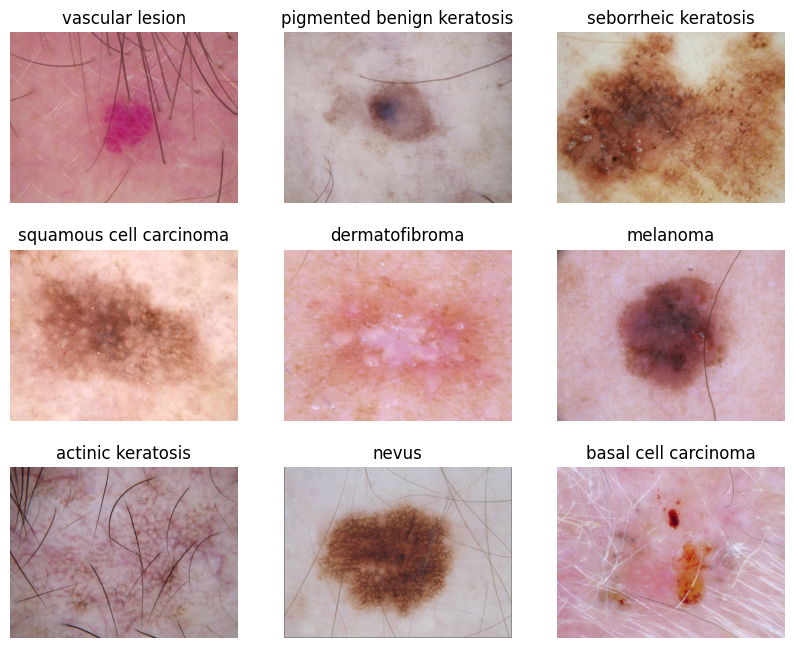

In [10]:
import matplotlib.pyplot as plt

from PIL import Image
fig=plt.figure(figsize=(10,8))
index = 1
for folder in train_data.iterdir():
  im=Image.open(next(folder.iterdir()))
  plt.subplot(3,3,index)
  plt.imshow(im)
  plt.title(str(folder).split('/')[-1])
  index+=1
  plt.axis("off")

#### Improve execution speed

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---
## Base Model building and Training

- We're aiming to construct a foundational CNN model capable of effectively identifying the 9 classes within the dataset.

- To ensure optimal neural network performance, we'll employ layers.experimental.preprocessing.Rescaling to normalize pixel values between 0 and 1.
- Considering that RGB channel values typically fall within the range of 0 to 255, standardizing these values to a range of 0 to 1 is more conducive for the network's operations. Additionally, let's establish a utility method to visualize the training outcomes.

In [12]:
def visualize_train_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

---
### Base Model

- Let's create and compile the base model.

In [13]:
# Model Network
base_model = Sequential([
         layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),

         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
base_model.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### Train the model

In [ ]:
epochs = 30

# Train the model with 30 epochs
history_base_model = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


#### Visualizing training results

In [ ]:
visualize_train_results(history_base_model)

#### Inference from Base Model:

- Following 30 epochs, the training accuracy soared to 0.93, in contrast to a notably lower validation accuracy of 0.54. Concurrently, while the training loss steadily decreased, the validation loss consistently rose after each epoch.

These observations strongly suggest that the model is exhibiting signs of poor performance, specifically indicating an issue with overfitting as the model excels in training but struggles to generalize to the validation data.

---


<a id='data_augment'></a>
## Data Augmentation
- It was evident that the base model was overfitting.
- Let's overcome the overfitting, by augmenting the data using random flip, rotation, zoom and contrast as shown below.

In [ ]:
# Augmentation layers
data_augument_layers = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomContrast(0.2)
])

> - Let's visualize augmentation strategy works for one instance of training image.

In [ ]:
# Visualize the augmentation strategy
for batch,labels in train_ds.take(1):
  im=batch[0]
  im=tf.reshape(im,(1,img_width,img_height,3))

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augument_layers(im)[0]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis("off")

---
<a id='base_augment_model'></a>
### Model building
### Base Model + Augmentation Layer

- Let's create and compile the base model with augmentation layers.

In [ ]:
# Model Network
aug_model = Sequential([
         # Augmentation Layers
         data_augument_layers,

         layers.Rescaling(1./255),

         #1st unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # 2nd unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # 3rd Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         layers.Flatten(),

         layers.Dense(128,activation="relu"),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

aug_model.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
aug_model.summary()

#### Train the model

In [ ]:
#use 30 epochs
epochs = 30

history_aug_model = aug_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the results

In [ ]:
visualize_train_results(history_aug_model)

#### Inference from Base model + Augmentation layers :
- At the conclusion of 30 epochs, the training accuracy settled at 0.59, closely shadowed by a validation accuracy of 0.56. Examination of the accuracy and loss plots reveals that the validation accuracy and loss begin to stabilize after several epochs. This trend indicates a partial mitigation of overfitting compared to the base model.

- The incorporation of augmentation layers has notably curbed overfitting, as evidenced by the reduced discrepancy between training and validation performances, though some level of overfitting persists, indicating room for further improvement.

In [ ]:
dropout_model_1 = Sequential([
         data_augument_layers,

         layers.Rescaling(1./255),

         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         layers.Flatten(),

         layers.Dense(128,activation="relu"),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

dropout_model_1.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

dropout_model_1.summary()

#### Training the model

In [ ]:
epochs = 30

history_aug_dropout_1 = dropout_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the results

In [ ]:
visualize_train_results(history_aug_dropout_1)

#### Inference from Base Model, Augmentation Layer and 1 dropout layer:

- Following 30 epochs, the introduction of a single dropout layer led to a slight alteration in training accuracy, reaching 0.60, and validation accuracy, reaching 0.54. Analysis of the accuracy and loss plots reveals a convergence between the training and validation outcomes, indicating an attempt to align.

- This signifies that the addition of a solitary dropout layer has marginally mitigated overfitting without a substantial impact on the model's performance.

---
### Base Model + Augmentation Layer + more dropout layers
- Now, add more dropout layers and experiment.

In [ ]:
# Model Network
aug_dropout_model_2 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
aug_dropout_model_2.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
aug_dropout_model_2.summary()

#### Training the model

In [ ]:
epochs = 30

# Train the model with 30 epochs
history_aug_dropout_2 = aug_dropout_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the results

In [ ]:
visualize_train_results(history_aug_dropout_2)

#### Conclusion from Base Model, Augmentation Layer and more dropout layers:

- After 30 epochs with the incorporation of additional dropout layers, the training accuracy declined to 0.55, while the validation accuracy settled at 0.48. Examination of the accuracy and loss plots reveals a near overlap between the training and validation outcomes, indicating a reduction in overfitting resulting from the augmented dropout layers.

- Moreover, the stagnant accuracy suggests a limitation in improvement owing to insufficient data. To address this, let's explore generating more data for each class.

---
---


## Class Distribution

- Frequently, real-world datasets exhibit class imbalance, where one class contains a notably higher number of samples than others.
- This imbalance can negatively impact the final model quality. Therefore, as a precautionary measure, it's crucial to assess the distribution of classes within the data as a sanity check.

In [ ]:
# Visualize the class distribution
data_detail_pd = pd.DataFrame(columns=["Dir_Name","Total Image(Train)","Total Percentage(Train)","Total Image(Test)","Total Percentage(Test)"])

dir_train = os.listdir(train_data)
dir_test = os.listdir(train_data)

for dir_name in dir_train:
   total_image_in_folder = len(list(train_data.glob(dir_name+"/*.jpg")))
   df = {"Dir_Name":dir_name,"Total Image(Train)":total_image_in_folder,"Total Percentage(Train)":round((total_image_in_folder/image_count_train)*100,2)}
   data_detail_pd = data_detail_pd.append(df,ignore_index=True)

data_detail_pd = data_detail_pd.set_index("Dir_Name")

for dir_name in dir_test:
   total_image_in_folder = len(list(train_data.glob(dir_name+"/*.jpg")))
   data_detail_pd.loc[dir_name,"Total Image(Test)"]  = total_image_in_folder
   data_detail_pd.loc[dir_name,"Total Percentage(Test)"]  = round((total_image_in_folder/image_count_test)*100,2)

display(data_detail_pd.sort_values(by="Total Percentage(Train)",ascending=False))

#### Question: Which class has the least number of samples?
- There are 77 images of **Seborrheic keratosis**, making up just 3.44% of the training data.

#### Question: Which classes dominate the data in terms proportionate number of samples?
- There are 462 images of **Pigmented benign keratosis**, accounting for 20.63% of the training data.

---
#### Handling class imbalances:
- We employ the Python package called `Augmentor` (accessible at https://augmentor.readthedocs.io/en/master/) to generate additional samples within all classes, ensuring none have an insufficient number of samples.

In [ ]:
!pip install Augmentor

The typical procedure for utilizing Augmentor involves these steps:

1. Create a Pipeline object that references the directory containing your original image dataset.
2. Specify a series of operations to apply to this dataset using the Pipeline object.
3. Execute these operations by invoking the sample() method within your Pipeline.

In [ ]:
path_to_training_dataset=str(train_data)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has saved the augmented images within the **output** sub-directory nested within each specific sub-directory for different types of skin cancer. Let's determine the total count of these augmented images.

In [ ]:
train_count = len(list(train_data.glob('*/*.jpg')))
print("Count of Train images : ",train_count)

aug_image_count_train = len(list(train_data.glob('*/output/*.jpg')))
print("Count of additional images after augmenting : ",aug_image_count_train)

total_image_count_train = train_count + aug_image_count_train
print("Count of Train images after augmenting : ",total_image_count_train)

#### Lets see the class distribution of augmented data after adding new images to the original training data.

In [ ]:
for dir_name in dir_train:
   total_image_in_folder = len(list(train_data.glob(dir_name+"/*.jpg"))) + len(list(train_data.glob(dir_name+"/output/*.jpg")))
   data_detail_pd.loc[dir_name,"Total Image(Train)"]  = total_image_in_folder
   data_detail_pd.loc[dir_name,"Total Percentage(Train)"]  = round((total_image_in_folder/total_image_count_train)*100,2)
data_detail_pd

Consequently, we've incorporated 500 images into all classes, aiming to maintain a more balanced distribution across the dataset.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)
train_ds

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

### Model Building
<a id='class_imbalance_model_1'></a>
### Base Model + Augmentation Layer + more dropout layers

- Let's retrain the Base Model + Augmentation Layer + more dropout layers with the new dataset.

In [ ]:
class_balanced_model_1 = Sequential([
         data_augument_layers,

         layers.Rescaling(1./255),

         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         layers.Flatten(),

         layers.Dense(128,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

class_balanced_model_1.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

class_balanced_model_1.summary()

#### Training the model

In [ ]:
epochs = 30

history_class_balanced_1 = class_balanced_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the model results

In [ ]:
visualize_train_results(history_class_balanced_1)

#### Inference from Base model + Augmentation Layer + more dropout layers:
- Following 30 epochs, the training accuracy stabilizes at 0.59, closely paralleled by the validation accuracy at 0.58. Analysis of the accuracy and loss plots reveals a convergence between the training and validation outcomes, with intermittent instances of the model displaying signs of underfitting.

To enhance the accuracy, let's introduce one batch normalization layer.


### Base model + Augmentation Layer + more dropout layers + 1 batch norm layer

In [ ]:
# Model Network
class_balanced_model_2 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_2.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

class_balanced_model_2.summary()

#### Training the model

In [ ]:
epochs = 30

# Train the model with 30 epochs
history_class_balanced_2 = class_balanced_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the model results

In [ ]:
visualize_train_results(history_class_balanced_2)

#### Inference from Base model +  Augmentation Layer + more dropout layers + 1 batch norm layer:
- After *30 epochs*, we could see the training accuracy to be *0.68* and validation accuracy to be *0.56*.
- From the accuracy and loss plots, we could see that the validation results are more dynamic.

>  Let's experiment by adding more batch normalization layers.

---
<a id='class_imbalance_model_3'></a>
### Base model + Augmentation Layer + more dropout layers + more batch norm layer

In [ ]:
# Model Network
class_balanced_model_3 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         layers.Dense(64,activation="relu"),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_3.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_3.summary()

#### Training the model

In [ ]:
epochs = 30

# Train the model with 30 epochs
history_class_balanced_3 = class_balanced_model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the model results

In [ ]:
visualize_train_results(history_class_balanced_3)

#### Inference from Base model + Augmentation Layer + more dropout layers + more batch norm layer:
- After *30 epochs*, we could see the training accuracy to be *0.71* and validation accuracy to be *0.45*.
- From the accuracy and loss plots, we could see that the validation results are more dynamic but still the training accuracy has improved.

>  Let's experiment by repositioning the batch normalization layers.

---
<a id='class_imbalance_model_4'></a>
### Base model + Augmentation Layer + more dropout layers + more batch norm layer (reposition)

In [ ]:
# Model Network
class_balanced_model_4 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same'),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same'),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same'),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.Dropout(0.2),

         layers.Dense(64,activation="relu"),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.Dropout(0.2),

         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_4.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_4.summary()

#### Training the model

In [ ]:
epochs = 50

# Train the model with 50 epochs
history_class_balanced_4 = class_balanced_model_4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the model results

In [ ]:
visualize_train_results(history_class_balanced_4)

#### Inference from Base model + Augmentation Layer + more dropout layers + more batch norm layer (Reposition):
- After *50 epochs*, we could see the training accuracy to be *0.77* and validation accuracy to be *0.45*.
- From the accuracy and loss plots, we could see that the validation results are more dynamic and there is no much change compared to the previous model.

>  Let's experiment by modifying the layers

---

<a id='class_imbalance_model_5'></a>
### Base model + Augmentation Layer + more dropout layers + more batch norm layer (Modification)

In [ ]:
# Model Network
class_balanced_model_5 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Batch normalization layer
         layers.BatchNormalization(),

         layers.Dense(64,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),

         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_5.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_5.summary()

#### Training the model

In [ ]:
epochs = 30

# Train the model with 30 epochs
history_class_balanced_5 = class_balanced_model_5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### Visualizing the model results

In [ ]:
visualize_train_results(history_class_balanced_5)

#### Inference from  Base model + Augmentation Layer + more dropout layers + more batch norm layer (Modification)
- After *30 epochs*, we could see the training accuracy to be *0.74* and validation accuracy to be *0.67*.
- This model looks to be **good** since the *metrics* are *high* as well as the *overfitting* is *less*.
---
---
<a id='analysis'></a>
## Analysis on Test Data

> We have built 9 models, let's evaluate these models using unseen test data.

### Test dataset creation

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

<a id='analysis_predict'></a>
### Prediction on test data

In [ ]:
def evaluate_accuracy(model, data):
  loss , accuracy = model.evaluate(data)
  return accuracy

model_dict = {
    "Base Model" : [base_model, history_base_model],
    "Base Model + Augmentation Layer" : [aug_model, history_aug_model],
    "Base Model + Augmentation Layer + 1 dropout layer" : [dropout_model_1, history_aug_dropout_1],
    "Base Model + Augmentation Layer + more dropout layers" : [aug_dropout_model_2, history_aug_dropout_2],
    "Base Model + Augmentation Layer + more dropout layers with Class balance" : [class_balanced_model_1, history_class_balanced_1],
    "Base model + Augmentation Layer + more dropout layers + 1 batch norm layer with Class balance" : [class_balanced_model_2, history_class_balanced_2],
    "Base model + Augmentation Layer + more dropout layers + more batch norm layer with Class balance" : [class_balanced_model_3, history_class_balanced_3],
    "Base model + Augmentation Layer + more dropout layers + more batch norm layer (reposition) with Class balance" : [class_balanced_model_4, history_class_balanced_4],
    "Base model + Augmentation Layer + more dropout layers + more batch norm layer (Modification) with Class balance" : [class_balanced_model_5, history_class_balanced_5]
}

# Report dataframe
report_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

# Run through the list of models to generate the report
for key, items in model_dict.items():
  df = {'Model' : key,  # Model name
        'Train Accuracy'     : round(items[1].history['accuracy'][-1],2),     # Get the accuracy of training data at the last epoch
        'Validation Accuracy': round(items[1].history['val_accuracy'][-1],2), # Get the accuracy of validation data at the last epoch
        'Test Accuracy'      : round(evaluate_accuracy(items[0], test_ds),2)} # Get the accuracy of test data using the trained model
  report_df = report_df.append(df, ignore_index=True)

# Display the report
display(report_df.sort_values(by=['Test Accuracy'], ascending=False))